# Build a predictive maintenance model for a delivery company - Classification

### Şirketler için tahmini bakım modeli oluşturacağız bunun için dengesiz veri setlerini ele almak için SMOTE (Sentetik Azınlık Aşırı Örnekleme Tekniği) uygulayacağız buradada bir örneğini açıklayacağım 

In [1]:
#İmport İşlemleri 

In [2]:
import warnings

import pandas as pd
warnings.filterwarnings('ignore')


### load işlemi yapıyoruz 

### İlk Önce Smote nasıl çalışıyor bir öğrenelim ve kaynaktaki örneği uygulayalım

In [3]:
#pip install imbalanced-learn

In [4]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# create a binary classification dataset
X, y = make_classification(
    n_samples=1000,
    n_features=2,
    n_redundant=0,
    n_clusters_per_class=1,
    weights=[0.98],
    random_state=125,
)

labels = Counter(y)
print("y labels after oversampling")
print(labels)

y labels after oversampling
Counter({0: 970, 1: 30})


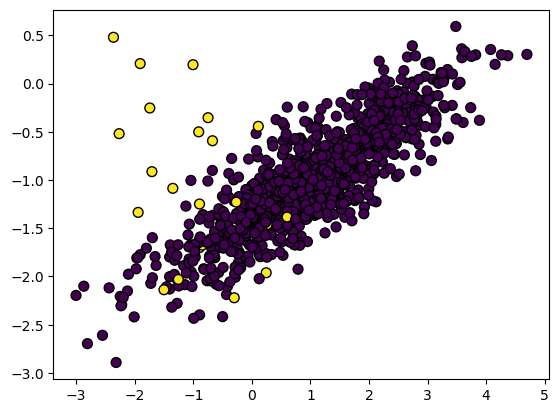

In [5]:
plt.scatter(X[:, 0], X[:, 1], marker="o", c=y, s=50, edgecolor="k");

In [6]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
result = cross_val_score(model, X, y, scoring="roc_auc", cv=cv, n_jobs=-1)
print("Mean AUC: %.3f" % np.mean(result))

Mean AUC: 0.625


In [7]:
over = SMOTE()

X, y = over.fit_resample(X, y)

labels = Counter(y)
print("y labels after oversampling")
print(labels)

y labels after oversampling
Counter({0: 970, 1: 970})


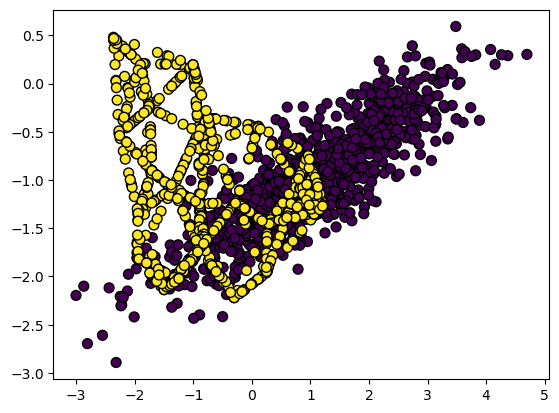

In [8]:
plt.scatter(X[:, 0], X[:, 1], marker="o", c=y, s=50, edgecolor="k");

In [9]:
model = DecisionTreeClassifier()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
result = cross_val_score(model, X, y, scoring="roc_auc", cv=cv, n_jobs=-1)

print("Mean AUC: %.3f" % np.mean(result))

Mean AUC: 0.830


In [10]:
#0.625 den 0.833 e çıktı

### Şimdi Kendi datamızı modelleyelim 

## Burada istenen veride bazı makinelerin belli zamanlarda durum verisi alınmış. Bu verilerle makinenin arıza verip vermeyeceğini tahmin etmeniz isteniyor.

- Load işlemleri

In [11]:
df = pd.read_csv('failure.csv')


# EDA - Exploratory Data Analysis

In [12]:
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        124494 non-null  object
 1   device      124494 non-null  object
 2   failure     124494 non-null  int64 
 3   attribute1  124494 non-null  int64 
 4   attribute2  124494 non-null  int64 
 5   attribute3  124494 non-null  int64 
 6   attribute4  124494 non-null  int64 
 7   attribute5  124494 non-null  int64 
 8   attribute6  124494 non-null  int64 
 9   attribute7  124494 non-null  int64 
 10  attribute8  124494 non-null  int64 
 11  attribute9  124494 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 11.4+ MB


In [14]:
df.describe()

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223868e+08,159.484762,9.940455,1.741120,14.222693,260172.858025,0.292528,0.292528,12.451524
std,0.029167,7.045960e+07,2179.657730,185.747321,22.908507,15.943021,99151.009852,7.436924,7.436924,191.425623
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.127675e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227957e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,0.000000,1.833084e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


In [15]:
df.shape

(124494, 12)

In [16]:
df.isnull().sum().sort_values(ascending=False)

date          0
device        0
failure       0
attribute1    0
attribute2    0
attribute3    0
attribute4    0
attribute5    0
attribute6    0
attribute7    0
attribute8    0
attribute9    0
dtype: int64

### Tarih Alanının Türünü değiştiriyorum

In [17]:
df['date'] = pd.to_datetime(df['date'])

In [18]:
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        124494 non-null  datetime64[ns]
 1   device      124494 non-null  object        
 2   failure     124494 non-null  int64         
 3   attribute1  124494 non-null  int64         
 4   attribute2  124494 non-null  int64         
 5   attribute3  124494 non-null  int64         
 6   attribute4  124494 non-null  int64         
 7   attribute5  124494 non-null  int64         
 8   attribute6  124494 non-null  int64         
 9   attribute7  124494 non-null  int64         
 10  attribute8  124494 non-null  int64         
 11  attribute9  124494 non-null  int64         
dtypes: datetime64[ns](1), int64(10), object(1)
memory usage: 11.4+ MB


In [20]:

df.failure.value_counts()

failure
0    124388
1       106
Name: count, dtype: int64

In [21]:

df.device.value_counts().sort_values(ascending=False)

device
W1F0FY92    304
Z1F0KKN4    304
Z1F0QK05    304
S1F0GCED    304
S1F0GGPP    304
           ... 
S1F136JY      5
S1F13BQX      5
S1F0RRB1      5
S1F04KSC      4
W1F0WJFT      3
Name: count, Length: 1168, dtype: int64

In [22]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

In [23]:
df.drop('date', axis=1, inplace=True)
df.drop('device', axis=1, inplace=True)
df

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,year,month,day
0,0,215630672,56,0,52,6,407438,0,0,7,2015,1,1
1,0,61370680,0,3,0,6,403174,0,0,0,2015,1,1
2,0,173295968,0,0,0,12,237394,0,0,0,2015,1,1
3,0,79694024,0,0,0,6,410186,0,0,0,2015,1,1
4,0,135970480,0,0,0,15,313173,0,0,3,2015,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
124489,0,18310224,0,0,0,10,353705,8,8,0,2015,11,2
124490,0,172556680,96,107,4,11,332792,0,0,13,2015,11,2
124491,0,19029120,4832,0,0,11,350410,0,0,0,2015,11,2
124492,0,226953408,0,0,0,12,358980,0,0,0,2015,11,2


In [24]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   failure     124494 non-null  int64
 1   attribute1  124494 non-null  int64
 2   attribute2  124494 non-null  int64
 3   attribute3  124494 non-null  int64
 4   attribute4  124494 non-null  int64
 5   attribute5  124494 non-null  int64
 6   attribute6  124494 non-null  int64
 7   attribute7  124494 non-null  int64
 8   attribute8  124494 non-null  int64
 9   attribute9  124494 non-null  int64
 10  year        124494 non-null  int32
 11  month       124494 non-null  int32
 12  day         124494 non-null  int32
dtypes: int32(3), int64(10)
memory usage: 10.9 MB


In [25]:
## Train Test Split

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop(['failure'], axis=1)
y = df['failure']

In [27]:

X = pd.get_dummies(X, columns=['year', 'month', 'day'], drop_first=True)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [29]:
#Smote

In [30]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(y_train_resampled.value_counts())

failure
0    87069
1    87069
Name: count, dtype: int64


In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

y_pred = rf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[37316     3]
 [   30     0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37319
           1       0.00      0.00      0.00        30

    accuracy                           1.00     37349
   macro avg       0.50      0.50      0.50     37349
weighted avg       1.00      1.00      1.00     37349



In [32]:
import algo_test

algo_test.model_fit_pred(X, y)


GaussianNB()
Accuracy: 0.9976973948432354
Confusion Matrix:
 [[37261    58]
 [   28     2]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     37319
           1       0.03      0.07      0.04        30

    accuracy                           1.00     37349
   macro avg       0.52      0.53      0.52     37349
weighted avg       1.00      1.00      1.00     37349

----------------------------------------
BernoulliNB()
Accuracy: 0.993761546493882
Confusion Matrix:
 [[37111   208]
 [   25     5]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     37319
           1       0.02      0.17      0.04        30

    accuracy                           0.99     37349
   macro avg       0.51      0.58      0.52     37349
weighted avg       1.00      0.99      1.00     37349

----------------------------------------
LogisticRegression()
Accuracy: 0

KNeighborsClassifier()